<a href="https://colab.research.google.com/github/zizizw/SupplyChainHW/blob/main/Alko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up (Import packages and Given Data)

In [138]:
import numpy as np
import pandas as pd
import math
import scipy.stats as st
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import itertools

In [139]:
### Set display options for comma separator and precision
pd.options.display.float_format = '{:,.2f}'.format

# Define the date you want to check
days = 365  # days_per_year
h   = 0.15  # holding_cost_per_day
tc  = 0.19  # transportaion_cost_per_unit
ctc = 0.29  # centralized transportaion_cost_per_unit
L   = 5     # supply_leadtime_days
T   = 6     # review_period_days
csl = 0.95  # critical value
# warehouse_cost = 50000


In [140]:

corr = 0
# Prompt the user to enter a value for 'corr'
#corr = float(input("Enter correlation (as scalar): "))

In [141]:
### Rawdata: average demand and standard deviation of demand for each part in each region
avg_demand = np.array([[35.48, 22.61, 17.66, 11.81,  3.36],
                       [ 2.48,  4.15,  6.15,  6.16,  7.49],
                       [ 0.48,  0.73,  0.80,  1.94,  2.54]])

std_demand = np.array([[ 6.98,  6.48,  5.26,  3.48,  4.49],
                       [ 3.16,  6.20,  6.39,  6.76,  3.56],
                       [ 1.98,  1.42,  2.39,  3.76,  3.98]])

num_demand = np.array([[ 10, 10, 10, 10, 10],
                       [ 20, 20, 20, 20, 20],
                       [ 70, 70, 70, 70, 70]])

n_parts, n_regions = avg_demand.shape[0], avg_demand.shape[1]

In [142]:
### create correlation matrix using provided scalar value (corr can also be provided as raw data)
corr_matrix = np.full((n_regions, n_regions), corr)
np.fill_diagonal(corr_matrix, 1) # Set diagonal elements to 1

In [143]:
z_score = st.norm.ppf(csl)
# z_score = 1.645

# Question 1

In [144]:
# Calculate inventory holding cost separately
inventory_holding_cost = np.sum(
    days * num_demand * (
        h * (z_score * std_demand * math.sqrt(T + L) + avg_demand * (T / 2 + L))
    )
)

# Calculate transportation cost separately
transportation_cost = np.sum(
    days * num_demand * avg_demand * tc
)

# Calculate total cost (sum of inventory holding and transportation costs)
total_cost = inventory_holding_cost + transportation_cost

# Print the results
print(f"Annual Inventory Holding Cost: ${inventory_holding_cost:,.2f}")
print(f"Annual Transportation Cost: ${transportation_cost:,.2f}")
print(f"Total Annual Cost: ${total_cost:,.2f}")

Annual Inventory Holding Cost: $1,347,070.96
Annual Transportation Cost: $131,217.14
Total Annual Cost: $1,478,288.09


# Question 2

In [145]:
# Evaluate NDC savings for each correlation value
corr_values = [0, 0.5, 1.0]  # Correlation values to evaluate

In [146]:
total_costs_with_central = []  # List to store total costs with centralization
savings_list = []  # List to store savings for each correlation

In [147]:
# Loop through correlation values
for corr in corr_values:
    # Create correlation matrix using the scalar value 'corr'
    corr_matrix = np.full((n_regions, n_regions), corr)
    np.fill_diagonal(corr_matrix, 1)  # Set diagonal elements to 1

    # Reshape the flattened matrix for centralized demand (just an example for now)
    centralize = np.ones((n_parts, n_regions))  # Default assumption: no centralization

    # Compute aggregate standard deviation for centralized choices
    agg_std_demand = np.diag(np.dot(np.dot(np.multiply(std_demand, centralize), corr_matrix),
                                   np.transpose(np.multiply(std_demand, centralize))))
    sqrt_agg_std_demand = np.sqrt(agg_std_demand)

    # Adjust standard deviation by dividing by the number of centralized regions for each part
    sum_columns = np.sum(centralize, axis=1, keepdims=True)
    sum_columns[sum_columns == 0] = 1  # Avoid division by zero
    sum_columns_inv = 1 / sum_columns

    # Update standard deviation values based on the centralization matrix
    sqrt_agg_std_demand2 = np.repeat(sqrt_agg_std_demand.reshape(n_parts, 1), n_regions, axis=1)
    sum_columns_inv2 = np.repeat(sum_columns_inv.reshape(n_parts, 1), n_regions, axis=1)

    std_demand_updated = np.array(centralize * sum_columns_inv2 * sqrt_agg_std_demand2 +
                                  (1 - centralize) * std_demand)

    # Centralized inventory holding cost (cycle stock + safety stock)
    centralized_inventory_holding_cost = np.sum(
        days * num_demand * (
            h * (z_score * std_demand_updated * math.sqrt(T + L) + avg_demand * (T / 2 + L))
        )
    )

    # Centralized transportation cost
    centralized_transportation_cost = np.sum(
        days * num_demand * avg_demand * (centralize * ctc + (1 - centralize) * tc)
    )

    # Total NDC cost with centralization
    total_centralized_cost = centralized_inventory_holding_cost + centralized_transportation_cost

    # Add the costs for comparison
    total_costs_with_central.append(total_centralized_cost)


    # Savings from NDC (centralization)
    savings = total_cost - total_centralized_cost
    savings_list.append(savings)


    # Print results for this correlation
    print(f"Correlation: {corr}")
    print(f"NDC Inventory Holding Cost: ${centralized_inventory_holding_cost:,.2f}")
    print(f"NDC Transportation Cost: ${centralized_transportation_cost:,.2f}")
    print(f"NDC Total Annual Cost: ${total_centralized_cost:,.2f}")
    print(f"Savings from NDC: ${savings:,.2f}\n")

Correlation: 0
NDC Inventory Holding Cost: $1,072,874.78
NDC Transportation Cost: $200,278.78
NDC Total Annual Cost: $1,273,153.57
Savings from NDC: $205,134.53

Correlation: 0.5
NDC Inventory Holding Cost: $1,233,881.14
NDC Transportation Cost: $200,278.78
NDC Total Annual Cost: $1,434,159.92
Savings from NDC: $44,128.17

Correlation: 1.0
NDC Inventory Holding Cost: $1,347,070.96
NDC Transportation Cost: $200,278.78
NDC Total Annual Cost: $1,547,349.74
Savings from NDC: $-69,061.65



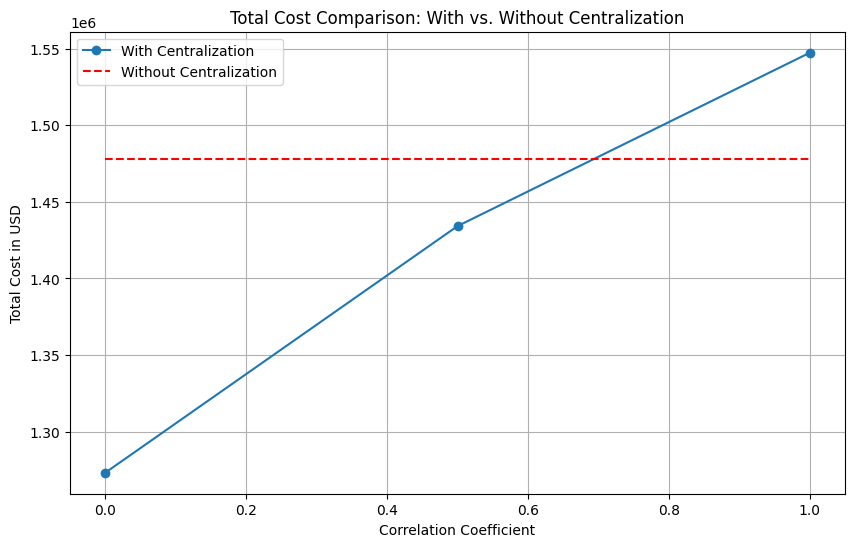

In [148]:
# Create a list of the same value as total_cost for plotting comparison
total_cost_without_central = [total_cost] * len(corr_values)

# Visualization
plt.figure(figsize=(10, 6))

# Plot the total cost with centralization
plt.plot(corr_values, total_costs_with_central, label="With Centralization", marker='o')

# Plot the total cost without centralization (constant value)
plt.plot(corr_values, total_cost_without_central, label="Without Centralization", linestyle='--', color='red')

# Adding labels and title
plt.xlabel('Correlation Coefficient')
plt.ylabel('Total Cost in USD')
plt.title('Total Cost Comparison: With vs. Without Centralization')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

# Question 3

In [149]:
# Objective function to maximize (using matrix calculations)
def objective_function(flat_matrix):

    centralize = flat_matrix.reshape((n_parts, n_regions))  # Reshape the flattened matrix to (3, 5)

    # Compute aggregate standard deviation for centralized choices
    agg_std_demand = np.diag(np.dot(np.dot(np.multiply(std_demand, centralize), corr_matrix),
                                    np.transpose(np.multiply(std_demand, centralize))))
    sqrt_agg_std_demand = np.sqrt(agg_std_demand)

    sum_columns = np.sum(centralize, axis=1, keepdims=True)
    sum_columns[sum_columns == 0] = 1  # Prevent division by zero
    sum_columns_inv = 1 / sum_columns

    # Adjust the standard deviation by dividing by the number of centralized regions for each part
    sqrt_agg_std_demand2 = np.repeat(sqrt_agg_std_demand.reshape(n_parts, 1), n_regions, axis=1)
    sum_columns_inv2 = np.repeat(sum_columns_inv.reshape(n_parts, 1), n_regions, axis=1)

    std_demand_updated = np.array(centralize * sum_columns_inv2 * sqrt_agg_std_demand2 + (1 - centralize) * std_demand)

    total_cost = sum(
        days * num_demand[i, j] *
        (h * (z_score * std_demand_updated[i, j] * math.sqrt(T + L) + avg_demand[i, j] * (T/2 + L)) +
         (avg_demand[i, j] * (centralize[i, j] * ctc + (1 - centralize[i, j]) * tc)))
        for i in range(n_parts) for j in range(n_regions)
    )

    return total_cost  # Negate for maximization

# Loop over correlation values
corr_values = [0, 0.5, 1]

for corr in corr_values:
    # Set up correlation matrix for the current correlation value
    corr_matrix = np.full((n_regions, n_regions), corr)
    np.fill_diagonal(corr_matrix, 1)  # Fill diagonal with 1

    # Initial guess for decision variables
    initial_guess = np.full((n_parts, n_regions), 0.5)
    initial_guess_flat = initial_guess.flatten()  # Flatten the initial guess for use in optimization

    # Bounds for decision variables (between 0 and 1)
    bounds = [(0, 1)] * (n_parts * n_regions)

    # Custom constraint enforcing the sum of each group (of 5) to not equal 1
    def binary_constraints(x):
        # Binary constraint to force variables close to 0 or 1
        return [xi * (1 - xi) for xi in x]

    # Constraints argument
    constraints = ({'type': 'ineq', 'fun': binary_constraints})

    # Optimization using minimize function from scipy
    result = minimize(objective_function, initial_guess_flat, bounds=bounds, constraints=constraints)

    # Extract the optimal solution as a 3x5 matrix
    optimal_soln_mat = np.round(result.x.reshape((n_parts, n_regions)))

    # Print the optimal solution and results for the current correlation value
    print(f"Correlation: {corr}")
    print(f"Minimum cost: ${(result.fun):>13,.2f}")
    print("\nOptimal Solution:\n   R1   R2   R3   R4   R5")
    for part in optimal_soln_mat:
        print(" ".join(f"{int(region):4}" for region in part))
    print("\n")

Correlation: 0
Minimum cost: $ 1,272,712.13

Optimal Solution:
   R1   R2   R3   R4   R5
   0    1    1    1    1
   1    1    1    1    1
   1    1    1    1    1


Correlation: 0.5
Minimum cost: $ 1,418,648.16

Optimal Solution:
   R1   R2   R3   R4   R5
   0    0    0    0    0
   1    1    1    1    1
   1    1    1    1    1


Correlation: 1
Minimum cost: $ 1,478,288.09

Optimal Solution:
   R1   R2   R3   R4   R5
   0    0    0    0    0
   0    0    0    0    0
   0    0    0    0    0


